# 1. Importación de Librerías

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans

# 2. Carga de Datos

In [18]:
df = pd.read_csv('data/train.csv')

# 3. Limpieza y Procesamiento de Datos

In [19]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Crear nuevas características
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = np.where(df['FamilySize'] == 1, 1, 0)

# Conversión de variables categóricas a dummies
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# Excluir columnas irrelevantes o no numéricas
df = df.drop(columns=['Name', 'Ticket', 'Cabin'])

# 4. Análisis Exploratorio de Datos (EDA)

## Análisis Univariado

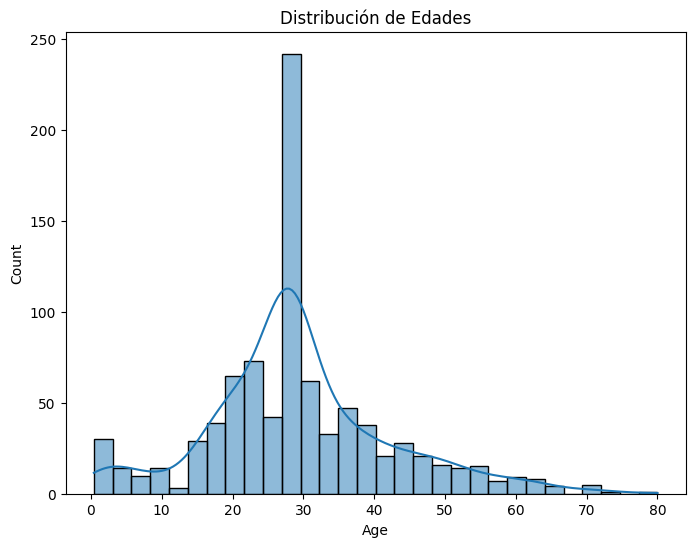

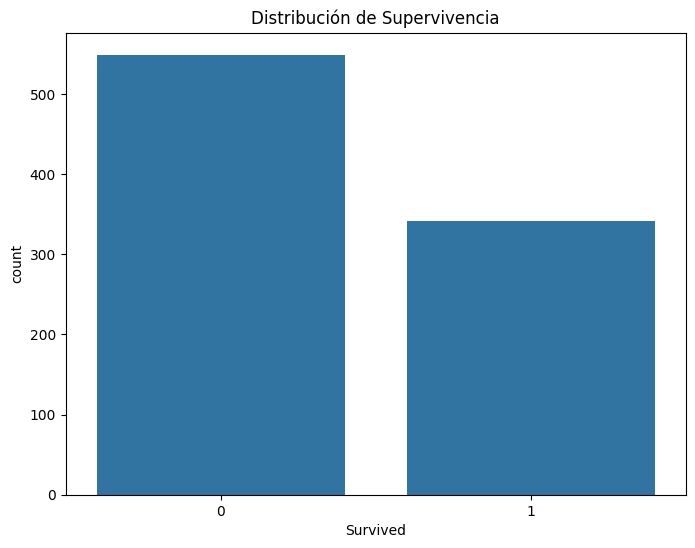

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], kde=True, bins=30)
plt.title('Distribución de Edades')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=df)
plt.title('Distribución de Supervivencia')
plt.show()

## Análisis Bivariado

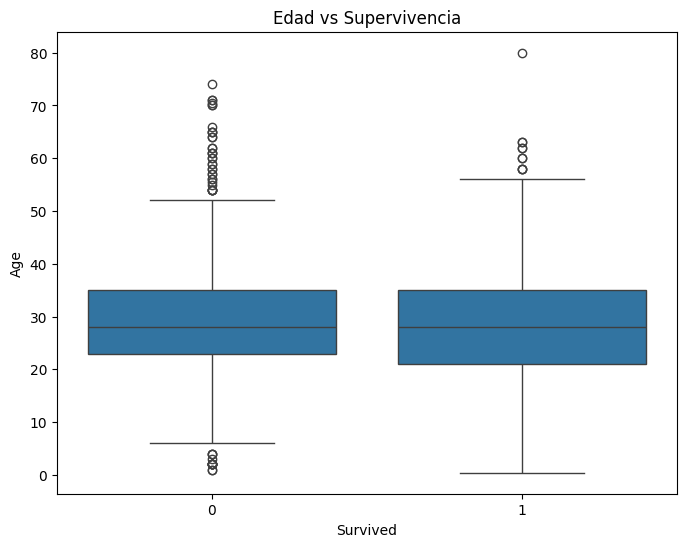

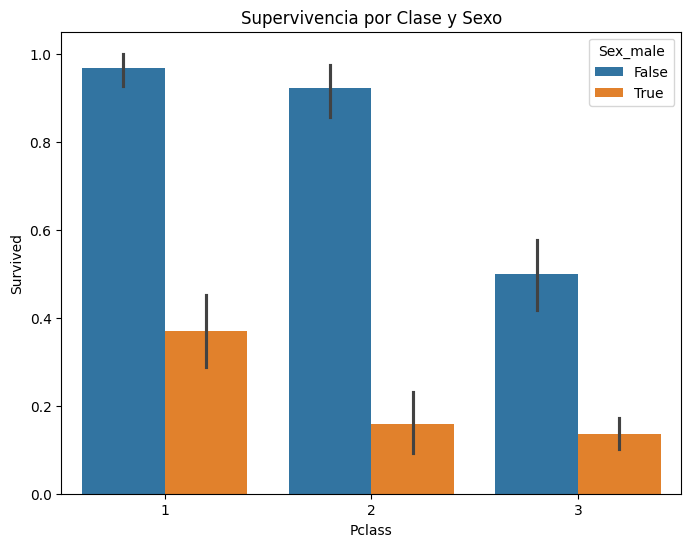

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Edad vs Supervivencia')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', hue='Sex_male', data=df)
plt.title('Supervivencia por Clase y Sexo')
plt.show()

## Análisis Multivariado

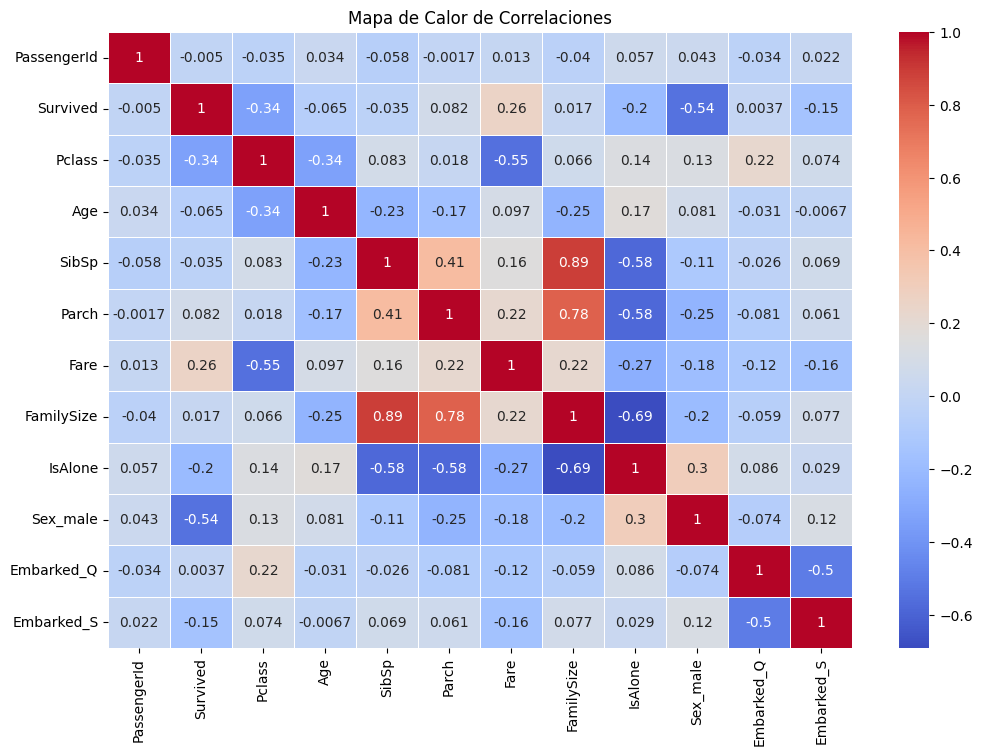

In [22]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones')
plt.show()

## Visualización Interactiva

In [23]:
fig = px.histogram(df, x='Survived', title='Distribución de Supervivientes')
fig.show()

fig = px.bar(df, x='Pclass', y='Survived', color='Sex_male', title='Supervivencia por Clase y Sexo')
fig.show()

## Clustering

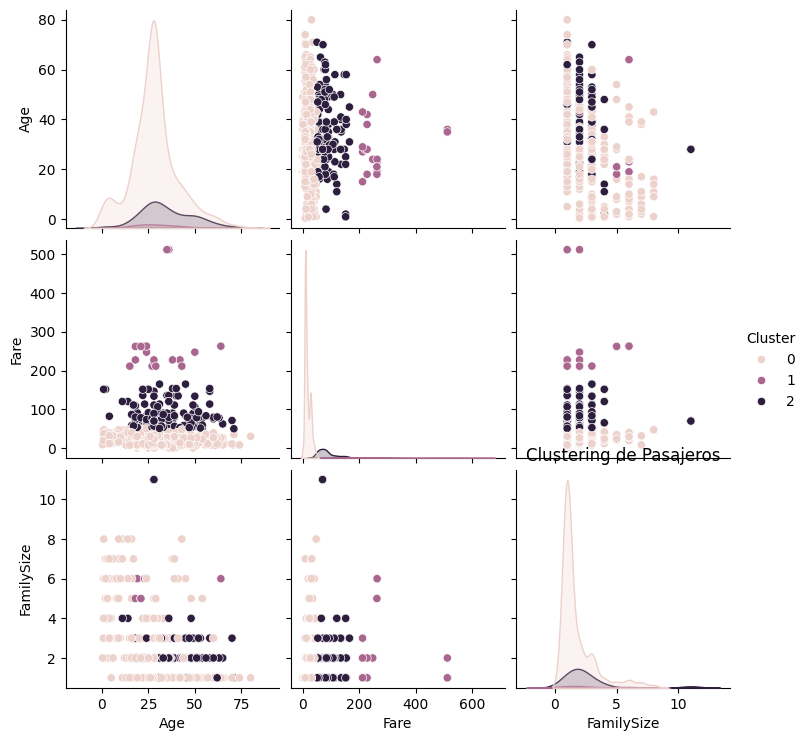

In [24]:
numeric_features = df[['Age', 'Fare', 'FamilySize', 'Pclass']]

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(numeric_features)

sns.pairplot(df, hue='Cluster', vars=['Age', 'Fare', 'FamilySize'])
plt.title('Clustering de Pasajeros')
plt.show()

# 5. Modelado Predictivo

## Selección de características numéricas y categóricas ya procesadas

In [25]:
features = ['Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S']
X = df[features]
y = df['Survived']

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Implementación de Modelos

In [26]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=300)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name}')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Logistic Regression
[[137  20]
 [ 32  79]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       157
           1       0.80      0.71      0.75       111

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.80       268

Random Forest
[[129  28]
 [ 32  79]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       157
           1       0.74      0.71      0.72       111

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268

K-Nearest Neighbors
[[131  26]
 [ 51  60]]
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       157
           1       0.70      0.54      0.61       111

    accuracy                           0.71       268
   ma

## Optimización de Random Forest con GridSearchCV

In [27]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)

print(f'Mejores parámetros (Random Forest): {grid_rf.best_params_}')

Mejores parámetros (Random Forest): {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


## Validación Cruzada para Random Forest

In [28]:
rf_model = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=5)
print(f'Precisión promedio con validación cruzada (Random Forest): {scores.mean():.4f}')

Precisión promedio con validación cruzada (Random Forest): 0.8238


## Análisis Contrafactual: ¿Qué pasaría si todos los pasajeros fueran de primera clase?

In [29]:
df['Pclass'] = 1
y_pred_all_first_class = grid_rf.predict(df[features])
print(f'Tasa de supervivencia si todos fueran de primera clase: {y_pred_all_first_class.mean():.2%}')

Tasa de supervivencia si todos fueran de primera clase: 41.19%


# 6. Conclusiones

In [30]:
print("Conclusiones:")
print("1. Las variables más influyentes en la supervivencia son el sexo, la clase del pasajero y la edad.")
print("2. El modelo Random Forest optimizado fue el más efectivo para predecir la supervivencia.")
print("3. Un análisis contrafactual sugiere que si todos los pasajeros hubieran estado en primera clase, la tasa de supervivencia habría sido significativamente mayor.")

Conclusiones:
1. Las variables más influyentes en la supervivencia son el sexo, la clase del pasajero y la edad.
2. El modelo Random Forest optimizado fue el más efectivo para predecir la supervivencia.
3. Un análisis contrafactual sugiere que si todos los pasajeros hubieran estado en primera clase, la tasa de supervivencia habría sido significativamente mayor.
